<a href="https://colab.research.google.com/github/junyu-chen-academic/Transformer/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
######################################
### importing libraries
######################################
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

seed = 2024
torch.manual_seed(seed)

# 1. Data Preprocessing

## 1.1 Word Embedding

In [2]:
###########################################################
###########################################################
# tokenize the sequences
def tokenize(sequence):

    # remove punctuation
    for punc in ["!", ",", ".", "?"]:
        sequence = sequence.replace(punc, "")

    # split the sequence on spaces and lowercase each token
    return [token.lower() for token in sequence.split(" ")]

def build_vocab(data):

    # tokenize the data and remove duplicates
    vocab = list(set(tokenize(data)))

    # sort the vocabulary
    vocab.sort()

    # assign an integer to each word
    vocab = {word:i for i, word in enumerate(vocab)}

    return vocab

## 1.2 Positional Encoding

The original mapping we applied in positional encoding is
$$
\begin{align}
    p_{k,2i} &= \sin(\frac{k}{10000^{\frac{2i}{d}}}), \\
    p_{k,2i+1} &= \cos(\frac{k}{10000^{\frac{2i}{d}}}),
\end{align}
$$
for $k \in \{1, \ldots, n\}$ and $i \in \{0, \ldots, \frac{d}{2} - 1\}$. However, this basic implementation is not efficient due to its use of nested loops.

Instead, we modify the divisor using logarithmic rules:
$$
\begin{align}
    \frac{1}{10000^{\frac{2i}{d}}} = e^{\frac{-2i \log(n)}{d}}.
\end{align}
$$
It is apparent that only two divisors are necessary for a $4$-dimensional embedding since the divisor only changes every $2i$.

In [3]:
###########################################################
###########################################################
class PositionalEncoding(nn.Module):

    def __init__(
        self,
        d_model: int,
        dropout: float = 0.0,
        max_length: int = 5000
    ):
        """
        Args:
          d_model:      dimension of embeddings
          dropout:      probability of randomly zeroes-out some of the input
          max_length:   max sequence length
        """
        super().__init__()

        # initialize dropout
        self.dropout = nn.Dropout(p=dropout)
        # create a N x d tensor of zeros
        pe = torch.zeros(max_length, d_model)

        # calculate the numerator
        # unsqueeze(1) adds a new dimension at the first axis (index 1), transforming the 1D tensor into a 2D column vector.
        k = torch.arange(0, max_length).unsqueeze(1)

        # calculate the denominator
        div_term = torch.exp(torch.arange(0, d_model, 2) * (- (math.log(10000.0) / d_model)))

        # calculate sine on even indices, and cosine on odd indices.
        pe[:, 0::2] = torch.sin(k * div_term)
        pe[:, 1::2] = torch.cos(k * div_term)

        # add dimension
        pe = pe.unsqueeze(0)

        # buffers are saved in state_dict but not trained by the optimizer
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor):
        """
        Args:
          x:        input embeddings (batch_size, seq_length, d_model)

        Returns:    embeddings + positional encodings (batch_size, seq_length, d_model)
        """
        # add positional encoding to the embeddings
        # note that the positional encoding tensor is sliced to match the length of the input sequence.
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)

        # perform dropout
        return self.dropout(x)

# 2. Model

Things to note:

1. we use nn.dropout to prevent overfitting. Dropout randomly zeroes out some values of the output.

2. We use the fully connected neural network in the feed forward layer.

## 2.1 Layers

### 2.1.1 Attention Layer

Each head undergoes single-head attention operation multiple times to obtain different attention scores:
$$
\begin{align}
    \mathbf{A}'_{(h)} &= \text{Attention}(\mathbf{Q}_{(h)},\mathbf{K}_{(h)},\mathbf{V}_{(h)}) = \text{softmax}(\frac{\mathbf{Q}_{(h)}\mathbf{K}_{(h)}^T}{\sqrt{d_{k}}})\mathbf{V}_{(h)}, \\
    \text{where }&
    \mathbf{Q}_{(h)}=\mathbf{X} \mathbf{W}_{q}^{(h)}, \quad
    \mathbf{K}_{(h)}=\mathbf{X} \mathbf{W}_{k}^{(h)}, \quad
    \mathbf{V}_{(h)}=\mathbf{X} \mathbf{W}_{v}^{(h)}.
\end{align}
$$

Here, $h$ denotes the number of heads, often $d_{k} = d_{v} = d/h$, and $\mathbf{W}_{q}^{(h)}, \mathbf{W}_{k}^{(h)}, \mathbf{W}_{v}^{(h)} \in \mathbb{R}^{d \times d_{k}}$.

Then, we concatenate attention outputs $\mathbf{A}'_{(h)}$ from all $h$ heads and linearly combine using a learnable weight matrix $\mathbf{W}_{a} \in \mathbb{R}^{hd_{v}\times d}$:
\begin{equation}
    \mathbf{A} = \text{Multi-Head}(\mathbf{Q},\mathbf{K},\mathbf{V}) = \text{Concat}(\mathbf{A}'_{(1)}, ..., \mathbf{A}'_{(h)}) \cdot W_{a},
\end{equation}
where $\mathbf{A} \in \mathbb{R}^{n \times d}$.

Note that the softmax function $\sigma : \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ is defined by the formula: $\sigma(\mathbf{z})_{i} = e^{z_{i}}/\sum_{j=1}^{n} e^{z_{j}}$ for $i = \{1,...,n\}$.

In [4]:
###########################################################
###########################################################
class MultiHeadAttention(nn.Module):

    def __init__(
        self,
        d_model: int = 512,
        n_heads: int = 8,
        bias: bool = True,
        dropout: float = 0,
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of self attention heads
            dropout:      probability of dropout occurring
        """
        super().__init__()
        torch.manual_seed(seed)
        assert d_model % n_heads == 0            # ensure an even num of heads
        self.d_model = d_model                   # dim (e.g. 512)
        self.n_heads = n_heads                   # 8 heads
        self.d_key = d_model // n_heads          # assume d_value equals d_key (e.g. 512/8=64)
        self.bias = bias                         # bias

        self.Wq = nn.Linear(d_model, d_model, bias)    # query weights
        self.Wk = nn.Linear(d_model, d_model, bias)    # key weights
        self.Wv = nn.Linear(d_model, d_model, bias)    # value weights
        self.Wo = nn.Linear(d_model, d_model, bias)    # output weights

        self.dropout = nn.Dropout(p=dropout)     # initialize dropout layer

    def scaled_dot_product_attention(
        self,
        Q: Tensor,
        K: Tensor,
        V: Tensor,
        mask=None
    ):
        # (32, 8, 10, 64) x (32, 8, 64, 10) -> (32, 8, 10, 10) = (batch_size, n_heads, q_length, k_length)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_key)

        # fill those positions of product as (-1e10) where mask positions are 0
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # apply softmax
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # multiply by values to obtain the final output
        # (batch_size, n_heads, q_length, k_length) x (batch_size, n_heads, v_length, d_key)
        # (32, 8, 10, 10) x (32, 8, 10, 64) -> (32, 8, 10, 64)
        output = torch.matmul(self.dropout(attn_probs), V)

        # (batch_size, n_heads, q_length, d_key) = (32, 8, 10, 64)
        return output, attn_probs

    def split_heads(
        self, x: Tensor
    ):
        # reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()

        # (batch_size, seq_length, d_model) -> (batch_size, seq_length, n_heads, d_key)
        # (32, 10, 512) -> (32, 10, 8, 64)
        x = x.view(batch_size, seq_length, self.n_heads, self.d_key)

        # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, seq_length, d_key)
        return x.transpose(1, 2)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        mask: Tensor = None
    ):
        """
        Args:
           query:         query vector         (batch_size, q_length, d_model)
           key:           key vector           (batch_size, k_length, d_model)
           value:         value vector         (batch_size, s_length, d_model)
           mask:          mask for decoder

        Returns:
           output:        attention values     (batch_size, q_length, d_model)
           attn_probs:    softmax scores       (batch_size, n_heads, q_length, k_length)
        """
        batch_size = key.size(0)

        # calculate query, key, and value tensors
        Q = self.Wq(query)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)
        K = self.Wk(key)                         # (32, 10, 512) x (512, 512) = (32, 10, 512)
        V = self.Wv(value)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)

        # split each tensor into n-heads to compute attention
        # (32, 10, 512) -> (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, seq_length, d_key)
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        #print(f"Wq weights shape after splitting: {self.Wq.weight}")
        #print(f"Q shape after splitting: {Q.size()}")
        #print(20*"#")

        # computes attention
        # scaled dot product -> QK^{T} / sqrt(d_key)
        # (32, 8, 10, 64) x (32, 8, 64, 10) x (32, 8, 10, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, v_length, d_key)
        attn_output, attn_probs = self.scaled_dot_product_attention(Q, K, V, mask)

        # combine the multiple heads
        # (32, 8, 10, 64) -> (32, 10, 8, 64)
        attn_output = attn_output.transpose(1, 2).contiguous()
        # reshape attention back to (32, 10, 512)
        # (32, 10, 8, 64) -> (32, 10, 512) = (batch_size, q_length, d_model)
        attn_output = attn_output.view(batch_size, -1, self.n_heads * self.d_key)

        # push through the final weight layer
        # (32, 10, 512) x (512, 512) = (32, 10, 512)
        output = self.Wo(attn_output)

        return output, attn_probs                         # return attn_probs for visualization of the scores

### 2.1.2 Add and Norm Layer

Layer normalization speeds up convergence.

The LayerNorm function $g: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ is defined by $g(\mathbf{z}, \gamma, \beta)_{i} = \beta + \gamma \frac{(z_{i} - \mu_{z})}{\sigma_{z}}$. Here, $\mu_{z} = \frac{1}{n} \sum_{i=1}^{n} z_{i}$ and $\sigma_{z} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(z_{i} - \mu_{z})^{2}}$ denote the mean and standard deviation respectively, $\gamma$ and $\beta$ are parameters of the LayerNorm function. After normalization, the input is scaled by $\gamma$ and shifted by $\beta$.

In [5]:
###########################################################
###########################################################
class LayerNorm(nn.Module):

    def __init__(
        self,
        d_model,
        eps=1e-5
    ):
        super().__init__()
        # initialize gamma to be all ones
        self.gamma = nn.Parameter(torch.ones(d_model))
        # initialize beta to be all zeros
        self.beta = nn.Parameter(torch.zeros(d_model))
        # eps: a small constant (1e-5) added to the variance to avoid division by zero during normalization.
        self.eps = eps

    def forward(self, src):
        # this computes the mean of the input src along the last dimension (-1), which represents the feature dimension.
        mean = src.mean(-1, keepdim=True)
        # this computes the variance of the input src along the last dimension (-1). unbiased=False means not divided by n-1 but by n.
        var = src.var(-1, keepdim=True, unbiased=False)
        # return the normalized value
        return self.gamma * (src - mean) / torch.sqrt(var + self.eps) + self.beta

### 2.1.3 Feed Forward Layer

It consists of two linear layers.

In [6]:
###########################################################
###########################################################
class PositionwiseFeedForward(nn.Module):

  def __init__(
      self,
      d_model: int,
      d_ffn: int,
      dropout: float
  ):
    """
    Args:
        d_model:      dimension of embeddings
        d_ffn:        dimension of feed-forward network,
                      generally set to a value about four times that of d_model.
        dropout:      probability of dropout occurring
    """
    super().__init__()

    self.w_1 = nn.Linear(d_model, d_ffn)
    self.w_2 = nn.Linear(d_ffn, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    Args:
        x:            output from attention (batch_size, seq_length, d_model)

    Returns:
        expanded-and-contracted representation (batch_size, seq_length, d_model)
    """
    # w_1(x).relu():            (batch_size, seq_length, d_model) x (d_model, d_ffn)  ->    (batch_size, seq_length, d_ffn)
    # w_2(w_1(x).relu()):       (batch_size, seq_length, d_ffn) x (d_ffn, d_model)    ->    (batch_size, seq_length, d_model)
    return self.w_2(self.dropout(self.w_1(x).relu()))

## 2.2 Encoder-Decoder Structure

### 2.2.1 Encoder Block

Stacking each encoder layer forms the encoder block. The original paper by Vaswani et al. stacked 6 encoder layers.



In [7]:
###########################################################
###########################################################
class EncoderLayer(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ffn: int,
        dropout: float
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = LayerNorm(d_model=d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
        # layer norm for position-wise ffn
        self.ffn_layer_norm = LayerNorm(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        src: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            src:          positionally embedded sequences   (batch_size, seq_length, d_model)
            src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)

        Returns:
            src:          sequences after self-attention    (batch_size, seq_length, d_model)
        """
        # pass embeddings through multi-head attention
        _src, attn_probs = self.attention(query=src, key=src, value=src, mask=src_mask)

        # residual add and norm
        src = self.attn_layer_norm(src + self.dropout(_src))

        # position-wise feed-forward network
        _src = self.positionwise_ffn(x=src)

        # residual add and norm
        src = self.ffn_layer_norm(src + self.dropout(_src))

        return src, attn_probs


###########################################################
###########################################################
class Encoder(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_layers: int,
        n_heads: int,
        d_ffn: int,
        dropout: float = 0.1
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_layers:     number of encoder layers
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # create n_layers encoders
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)]
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        src: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            src:          embedded sequences                (batch_size, seq_length, d_model)
            src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)

        Returns:
            src:          sequences after self-attention    (batch_size, seq_length, d_model)
        """

        # pass the sequences through each encoder
        for layer in self.layers:
            src, attn_probs = layer(src=src, src_mask=src_mask)

        self.attn_probs = attn_probs

        return src

### 2.2.2 Decoder Block

Stacking each decoder layer forms the decoder block. The original paper by Vaswani et al. stacked 6 decoder layers.

In [8]:

###########################################################
###########################################################
class DecoderLayer(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ffn: int,
        dropout: float
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()
        # masked multi-head attention sublayer
        self.masked_attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for masked multi-head attention
        self.masked_attn_layer_norm = LayerNorm(d_model=d_model)

        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = LayerNorm(d_model=d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
        # layer norm for position-wise ffn
        self.ffn_layer_norm = LayerNorm(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        trg: Tensor,
        src: Tensor,
        trg_mask: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            trg:          target embedded sequences                (batch_size, trg_seq_length, d_model)
            src:          source embedded sequences                (batch_size, src_seq_length, d_model)
            trg_mask:     mask for the target sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
            src_mask:     mask for the source sequences            (batch_size, 1, 1, src_seq_length)

        Returns:
            trg:          sequences after self-attention    (batch_size, trg_seq_length, d_model)
            attn_probs:   attention softmax scores          (batch_size, n_heads, trg_seq_length, src_seq_length)
        """
        # pass trg embeddings through masked multi-head attention
        _trg, attn_probs = self.masked_attention(query=trg, key=trg, value=trg, mask=trg_mask)

        # residual add and norm
        trg = self.masked_attn_layer_norm(trg + self.dropout(_trg))

        # pass trg and src embeddings through multi-head attention
        _trg, attn_probs = self.attention(query=trg, key=src, value=src, mask=src_mask)

        # residual add and norm
        trg = self.attn_layer_norm(trg + self.dropout(_trg))

        # position-wise feed-forward network
        _trg = self.positionwise_ffn(x=trg)

        # residual add and norm
        trg = self.ffn_layer_norm(trg + self.dropout(_trg))

        return trg, attn_probs

###########################################################
###########################################################
class Decoder(nn.Module):

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        n_layers: int,
        n_heads: int,
        d_ffn: int,
        dropout: float = 0.1
    ):
        """
        Args:
            vocab_size:   size of the vocabulary
            d_model:      dimension of embeddings
            n_layers:     number of encoder layers
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # create n_layers encoders
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)]
        )
        self.dropout = nn.Dropout(p=dropout)
        # set output layer
        self.Wo = nn.Linear(d_model, vocab_size)

    def forward(
        self,
        trg: Tensor,
        src: Tensor,
        trg_mask:
        Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            trg:          embedded sequences                (batch_size, trg_seq_length, d_model)
            src:          encoded sequences from encoder    (batch_size, src_seq_length, d_model)
            trg_mask:     mask for the sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
            src_mask:     mask for the sequences            (batch_size, 1, 1, src_seq_length)

        Returns:
            output:       sequences after decoder           (batch_size, trg_seq_length, vocab_size)
            attn_probs:   self-attention softmax scores     (batch_size, n_heads, trg_seq_length, src_seq_length)
        """

        # pass the sequences through each decoder
        for layer in self.layers:
            trg, attn_probs = layer(trg=trg, src=src, trg_mask=trg_mask, src_mask=src_mask)

        self.attn_probs = attn_probs

        return self.Wo(trg)

# 3. Simulation AR(1)

### 3.1 Functions

In [9]:
######################################
### Creat dataloader
######################################
def split_and_build_dataloader(
    X: np.array,
    Y: np.array,
    batch_size: int,
    split_ratio: float = 0.8,
    shuffle: bool = True
):
    """
    splits data into training and test sets, then builds DataLoaders.

    Args:
        X:                  Input features.
        Y:                  Target labels.
        batch_size:         Batch size for DataLoader.
        split_ratio:        Ratio for splitting the data into train and test sets. Defaults to 0.8.

    Returns:
        dataloader_train:   DataLoader for training data.
        dataloader_test:    DataLoader for test data.
    """
    # Calculate the index for splitting
    n = len(X)
    split_index = int(split_ratio * n)

    # Split the data
    X_train, Y_train = X[:split_index], Y[:split_index]
    X_test, Y_test = X[split_index:], Y[split_index:]

    print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
    print("X_test:", X_test.shape, "Y_test:", Y_test.shape)

    # Create TensorDatasets
    dataset_train = TensorDataset(Tensor(X_train), Tensor(Y_train))
    dataset_test = TensorDataset(Tensor(X_test), Tensor(Y_test))

    # Create DataLoaders
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=shuffle)

    return dataloader_train, dataloader_test

######################################
### Model Training
######################################
def train_model(
      model: nn.Module,
      dataloader: DataLoader,
      learning_rate: float,
      epochs: int,
      criterion: nn.Module = None,
      mask_or_not: bool = False
):
    """
    Trains the given model on data using an optimizer and loss function.

    Args:
        model:            The model to train.
        dataloader:       DataLoader to provide training data.
        learning_rate:    Learning rate for the optimizer.
        epochs:           Number of training epochs.
        criterion:        Loss function, defaults to MSELoss.
        mask_or_not:      Whether to apply a mask, defaults to False.

    Returns:
        nn.Module:        The trained model.
    """
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if criterion is None:
        criterion = nn.MSELoss()

    epoch_losses = []

    for epoch in range(epochs):

        epoch_loss = 0

        for input, target in dataloader:

            optimizer.zero_grad()
            # forward pass
            predicted = model(input, mask_or_not=mask_or_not)

            # calculate loss
            loss = criterion(predicted, target)
            # backward pass
            loss.backward()
            # optimization
            optimizer.step()

            # Accumulate loss for the current epoch
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        epoch_losses.append(epoch_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}")

    return model, epoch_losses

######################################
### Model Evaluation
######################################
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    mask_or_not: bool = False,

):
    """
    Evaluates the given model on data.

    Args:
        model:            The model to evaluate.
        dataloader:       DataLoader to provide evaluation data.

    Returns:
        tuple: A tuple containing:
            - predictions (np.ndarray):   Predicted values.
            - mse (float):                The mean squared error (MSE) between the model's predictions and targets.
    """
    model.eval()

    # lists
    predictions = []
    targets = []

    with torch.no_grad():

        for input, target in dataloader:
            # perform forward pass
            predicted = model(input, mask_or_not=mask_or_not)

            # store predictions and actual values
            predictions.append(predicted.numpy())
            targets.append(target.numpy())

    # convert the lists to numpy arrays
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    # calculate MSE for evaluation
    mse = np.mean((predictions - targets) ** 2)
    print(f"Mean Squared Error: {mse:.4f}")

    return predictions, mse

######################################
### Plotting
######################################
def plot_predictions(
    y_pred: np.array,
    y: np.array,
    split_ratio: int,
    filename: str
):
    """
    Plots one-step-ahead predictions along with training and test data.

    Args:
        y:                  All target data
        y_pred:             Array of predicted values for the test data.
        split_ratio:        Ratio for splitting the data into train and test sets.
        filename:           Filename to save the plot.

    Returns:
        None
    """
    n = len(y)
    split_index = int(split_ratio * n)

    plt.figure(figsize=(16, 4))

    # Plot training data
    plt.plot(np.arange(split_index), y[:split_index], label='Training Data', color='blue', alpha=0.5)

    # Plot test data
    plt.plot(np.arange(split_index, n), y[split_index:], label='Test Data', color='green', alpha=0.5)

    # Plot predicted values
    plt.plot(np.arange(split_index, n), y_pred, label='Predicted Values', color='red', alpha=0.7)

    # Set titles and labels
    plt.title('One-Step-Ahead Prediction')
    plt.xlabel('Time Period')
    plt.legend()
    plt.grid()

    # Save and display plot
    plt.savefig(filename)
    plt.show()

######################################
### Plotting loss
######################################
def plot_loss(epoch_losses):
    """
    Plots the loss values over epochs.

    Args:
        epoch_losses: A list of loss values, one for each epoch.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)

    # Save and display plot
    plt.show()

######################################
### Output Weights
######################################
def output_weights(model: nn.Module):
    """
    Prints the trained weights of a given model.

    Args:
        model (nn.Module): The trained model whose weights are to be printed.

    Returns:
        weights (dict): Dictionary containing the weights of the model.
    """
    weights = {}
    for name, param in model.named_parameters():
      if param.requires_grad:
        #print("#" * 20, "\nTrained Model Weights:")
        #print(f"{name}: {param.data}")
        weights[name] = param.data

    return weights

######################################
### Reshape the Input data
######################################
def reshape_input(
    data: np.array,
    n: int,
    sequence_length: int,
    d_model: int
):
  X = np.zeros((n-sequence_length, sequence_length, d_model))

  # fill the first slice of X (single dimension)
  for i in range(n-sequence_length):
    X[i, :, 0] = data[i : i+sequence_length]

  # duplicate across d_model
  for d in range(1, d_model):
    X[:, :, d] = X[:, :, 0]

  Y = data[sequence_length:].reshape(-1, 1)

  return X, Y

### 3.2 Model Structure

In [10]:
class TimeSeriesAttention(nn.Module):
    def __init__(
        self,
        sequence_length: int,
        d_model: int = 512,
        d_ffn: int = 32,
        n_heads: int = 8,
        dropout: float = 0.0,
        bias_att: bool = False
    ):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout, bias=bias_att)
        #self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, bias=False, batch_first=True)

        self.feed_forward = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
        self.linear1 = nn.Linear(d_model, 1)
        self.linear2 = nn.Linear(sequence_length, 1)
        self.relu = nn.ReLU()

    def forward(
        self,
        x: Tensor,
        mask_or_not: bool = False
    ):
        if mask_or_not == True:
          mask_matrix = torch.tril(torch.ones((x.size(1), x.size(1))))
          attention_out, _ = self.attention(x, x, x, mask_matrix)  # Using same input for query, key, value
        else:
          attention_out, _ = self.attention(x, x, x)  # Using same input for query, key, value

        #print('#'*20)
        #print(attention_out)

        # the output of ffn -> (batch_size, sequence_length, d_model)
        output = self.relu(attention_out + 0.3)
        output = self.feed_forward(attention_out)
        #print(output)
        #print('#'*20)

        # reduce the dimensions to 1 -> (batch_size, sequence_length, 1)
        output = self.linear1(output)
        # remove the last dimension -> (batch_size, sequence_length)
        output = output.squeeze(-1)
        # reduce the last dimension -> -> (batch_size, 1)
        output = self.linear2(output)

        return output

### 3.3 Single Run

X_train: (799, 1, 1) Y_train: (799, 1)
X_test: (200, 1, 1) Y_test: (200, 1)
Epoch [1/120], Loss: 0.0233
Epoch [2/120], Loss: 0.0333
Epoch [3/120], Loss: 0.0340
Epoch [4/120], Loss: 0.0343
Epoch [5/120], Loss: 0.0339
Epoch [6/120], Loss: 0.0345
Epoch [7/120], Loss: 0.0345
Epoch [8/120], Loss: 0.0344
Epoch [9/120], Loss: 0.0344
Epoch [10/120], Loss: 0.0343
Epoch [11/120], Loss: 0.0344
Epoch [12/120], Loss: 0.0344
Epoch [13/120], Loss: 0.0345
Epoch [14/120], Loss: 0.0343
Epoch [15/120], Loss: 0.0344
Epoch [16/120], Loss: 0.0343
Epoch [17/120], Loss: 0.0344
Epoch [18/120], Loss: 0.0344
Epoch [19/120], Loss: 0.0343
Epoch [20/120], Loss: 0.0344
Epoch [21/120], Loss: 0.0343
Epoch [22/120], Loss: 0.0343
Epoch [23/120], Loss: 0.0343
Epoch [24/120], Loss: 0.0343
Epoch [25/120], Loss: 0.0343
Epoch [26/120], Loss: 0.0343
Epoch [27/120], Loss: 0.0343
Epoch [28/120], Loss: 0.0343
Epoch [29/120], Loss: 0.0343
Epoch [30/120], Loss: 0.0342
Epoch [31/120], Loss: 0.0343
Epoch [32/120], Loss: 0.0343
Epoch

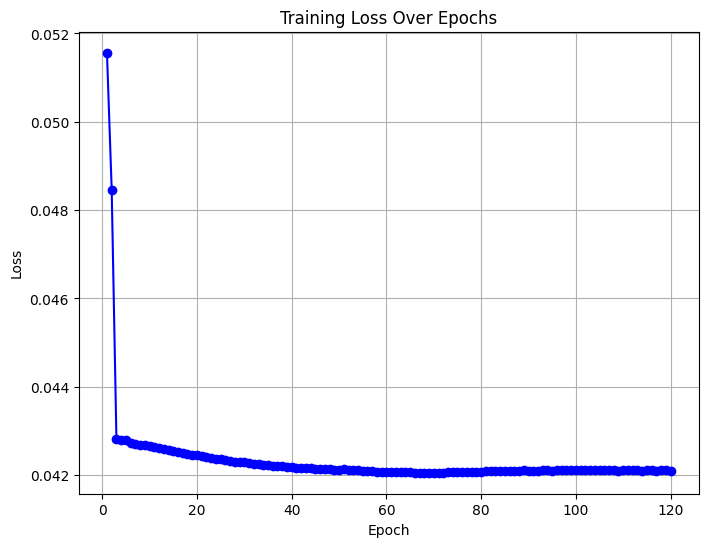

Mean Squared Error: 0.0371


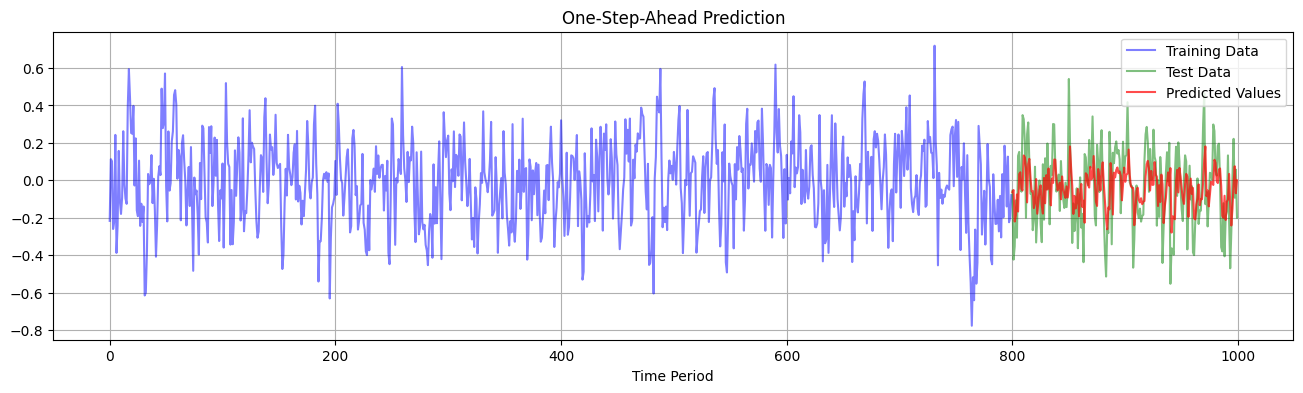

In [17]:
seed = 123
#seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)
######################################
### Data Generation Process AR(1)
######################################
phi = 0.4
sigma = 0.2 # sd. of noise
n = 1000 
sequence_length = 1 
d_model = 1 

y = np.zeros(n)

# generate white noise
epsilon = np.random.normal(0, sigma, n)

# initialize the first value of the series
y[0] = epsilon[0]

# generate AR(1) time series
for t in range(1, n):
    y[t] = phi * y[t-1] + epsilon[t]
    #y[t] = np.sin(y[t-1]) + epsilon[t]

######################################
### Model training
######################################
n_heads = 1
d_ffn = 1
dropout = 0.0
split_ratio = 0.8
shuffle = False

learning_rate = 0.015
epochs = 120
batch_size = 8

X, Y = reshape_input(y, n, sequence_length, d_model)
dataloader_train, dataloader_test = split_and_build_dataloader(X, Y, batch_size=batch_size, split_ratio = split_ratio, shuffle=shuffle)

# model initialization
model_ar1 = TimeSeriesAttention(
    sequence_length=sequence_length,
    d_model=d_model,
    d_ffn=d_ffn,
    n_heads=n_heads,
    dropout=dropout, bias_att=False
)

# train the model
model_trained, epoch_losses = train_model(model_ar1, dataloader_train, learning_rate, epochs)
weights = output_weights(model_trained)
print(weights)
plot_loss(epoch_losses)

# evaluate the model
y_pred, mse = evaluate_model(model_ar1, dataloader_test)
plot_predictions(y_pred=y_pred, y=y, split_ratio=split_ratio, filename="ar1_pred.png")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  800
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 124.444
Date:                Sat, 12 Oct 2024   AIC                           -242.887
Time:                        16:47:51   BIC                           -228.833
Sample:                             0   HQIC                          -237.488
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.012      0.015      0.988      -0.023       0.024
ar.L1          0.3904      0.031     12.477      0.000       0.329       0.452
sigma2         0.0429      0.002     20.782      0.0

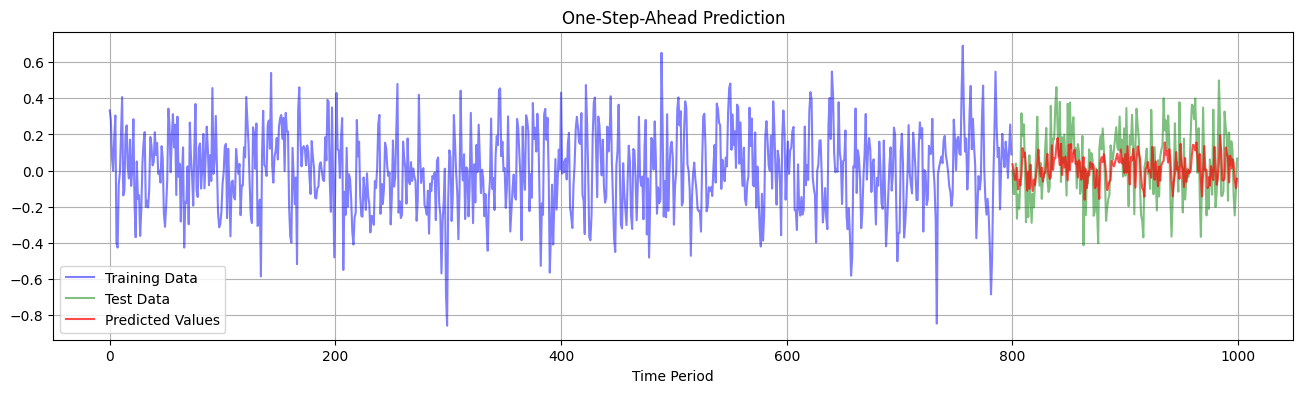

In [12]:
######################################
### Estimation with AR(1)
######################################
# split data into training (80%) and testing (20%)
split_index = int(0.8 * n)
train_data = y[:split_index]
test_data = y[split_index:]

# fit AR(1) model using statsmodels
ar_model = sm.tsa.ARIMA(train_data, order=(1, 0, 0))  # AR(1) is ARIMA with order (1,0,0)
ar_model_fit = ar_model.fit()
print(ar_model_fit.summary())
# get the estimated parameter
phi_estimated = ar_model_fit.params[1]  # AR coefficient
intercept_estimated = ar_model_fit.params[0]

# one-step-ahead prediction
predictions = []
last_observed_value = train_data[-1]  # Last value from training data

for t in range(len(test_data)):
  next_prediction = intercept_estimated + phi_estimated * last_observed_value
  predictions.append(next_prediction)
  last_observed_value = test_data[t]

# use the fitted AR(1) model to predict one-step ahead
#predictions = ar_model_fit.predict(start=split_index, end=n-1, dynamic=True)
# evaluate model performance using MSE
mse = np.mean((test_data - predictions) ** 2)
print(f"One-Step-Ahead Prediction MSE: {mse:.4f}")

# call the plotting function
plot_predictions(predictions, y, split_ratio, 'ar1_pred_ols.png')

### 3.4 Multiple Run

Training with batch size: 1
X_train: (799, 1, 1) Y_train: (799, 1)
X_test: (200, 1, 1) Y_test: (200, 1)
Epoch [1/120], Loss: 0.0001
Epoch [2/120], Loss: 0.0002
Epoch [3/120], Loss: 0.0003
Epoch [4/120], Loss: 0.0003
Epoch [5/120], Loss: 0.0005
Epoch [6/120], Loss: 0.0006
Epoch [7/120], Loss: 0.0004
Epoch [8/120], Loss: 0.0005
Epoch [9/120], Loss: 0.0005
Epoch [10/120], Loss: 0.0005
Epoch [11/120], Loss: 0.0005
Epoch [12/120], Loss: 0.0005
Epoch [13/120], Loss: 0.0005
Epoch [14/120], Loss: 0.0005
Epoch [15/120], Loss: 0.0005
Epoch [16/120], Loss: 0.0005
Epoch [17/120], Loss: 0.0006
Epoch [18/120], Loss: 0.0005
Epoch [19/120], Loss: 0.0006
Epoch [20/120], Loss: 0.0006
Epoch [21/120], Loss: 0.0006
Epoch [22/120], Loss: 0.0006
Epoch [23/120], Loss: 0.0006
Epoch [24/120], Loss: 0.0006
Epoch [25/120], Loss: 0.0006
Epoch [26/120], Loss: 0.0006
Epoch [27/120], Loss: 0.0006
Epoch [28/120], Loss: 0.0006
Epoch [29/120], Loss: 0.0006
Epoch [30/120], Loss: 0.0006
Epoch [31/120], Loss: 0.0006
Epoch 

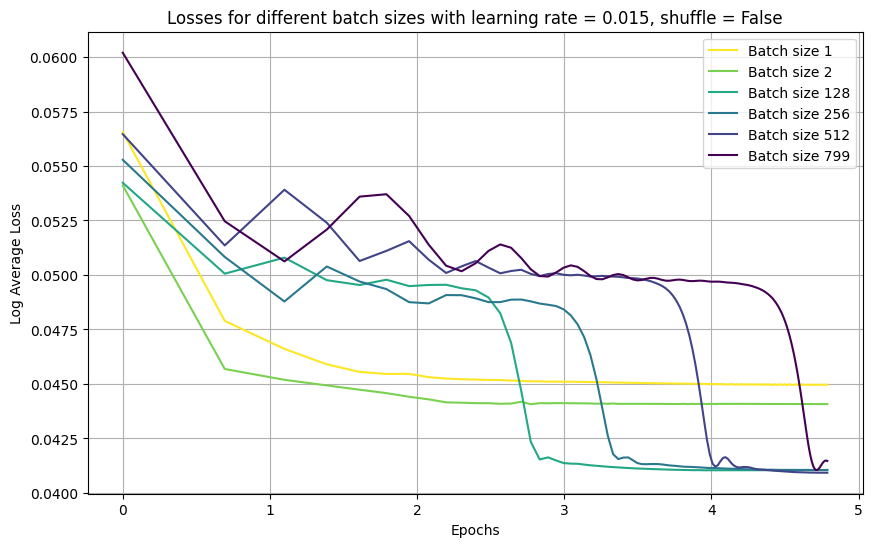

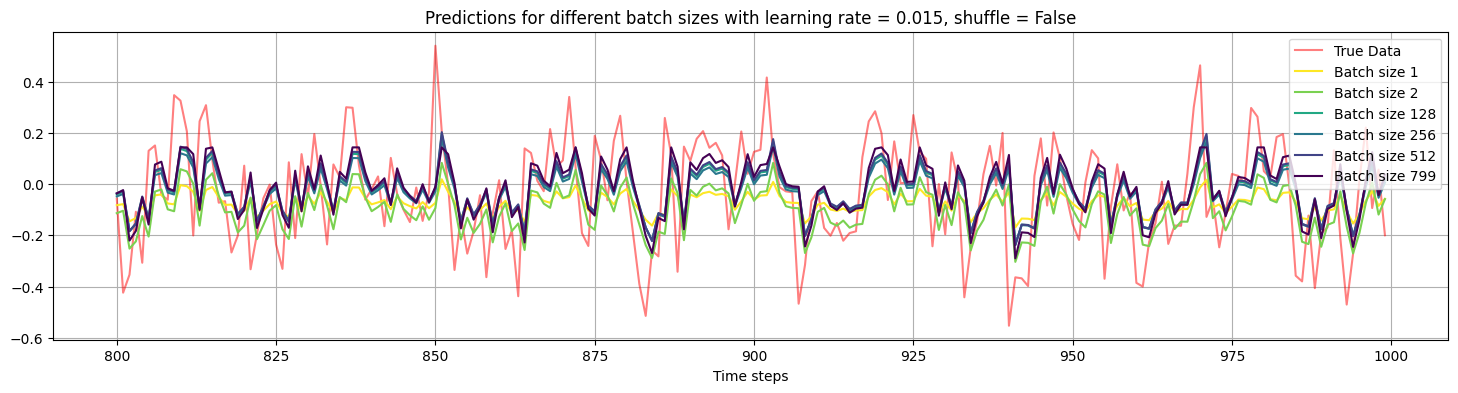

In [21]:
batch_sizes = [1, 2, 128, 256, 512, 799]
###########################################################
### Pipeline
###########################################################
def pipeline(
        X, Y, split_ratio,
        batch_size, sequence_length, d_model, 
        d_ffn, n_heads, dropout, 
        learning_rate, epochs
):  
    # build dataloader
    dataloader_train, dataloader_test = split_and_build_dataloader(X, Y, batch_size=batch_size, split_ratio=split_ratio, shuffle=shuffle)
    # model train
    model = TimeSeriesAttention(
        sequence_length, d_model, d_ffn, n_heads,
        dropout=dropout, bias_att=False
    )
    model_trained, epoch_losses = train_model(model, dataloader_train, learning_rate, epochs)

    y_pred, mse = evaluate_model(model_trained, dataloader_test)

    return model_trained, epoch_losses, y_pred, mse

###########################################################
###########################################################
# model train
all_epoch_losses = {}
all_predictions = {}

# loop over different batch sizes
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")

    model_trained, epoch_losses, y_pred, mse = pipeline(X, Y, split_ratio, batch_size, sequence_length, d_model, d_ffn, n_heads, dropout, learning_rate, epochs)

    all_epoch_losses[batch_size] = epoch_losses
    all_predictions[batch_size] = y_pred
    

###########################################################
###########################################################
colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))[::-1]

# plot the losses for all batch sizes
plt.figure(figsize=(10, 6))
for i, (batch_size, losses) in enumerate(all_epoch_losses.items()):
    #plt.plot(np.log(losses), label=f'Batch size {batch_size}', color=colors[i])
    epochs_range = np.arange(1, len(losses) + 1)
    plt.plot(np.log(epochs_range), losses, label=f'Batch size {batch_size}', color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Log Average Loss')
plt.title(f'Losses for different batch sizes with learning rate = {learning_rate}, shuffle = {shuffle}')
plt.legend()
plt.grid(True)
#plt.savefig(f'batch_sizes_losses_comparison_with_{learning_rate}_lr_{shuffle}_shuffle.png')  # Save the plot to a file
plt.show()

# plot the predictions for all batch sizes
plt.figure(figsize=(18, 4))
split_index = int(split_ratio * n)
plt.plot(np.arange(split_index, n), y[split_index:], label='True Data', color='red', alpha=0.5)
for i, (batch_size, y_pred) in enumerate(all_predictions.items()):
    plt.plot(range(split_index, split_index + len(y_pred)), y_pred, label=f'Batch size {batch_size}', color=colors[i])

plt.xlabel('Time steps')
plt.title(f'Predictions for different batch sizes with learning rate = {learning_rate}, shuffle = {shuffle}')
plt.legend()
plt.grid(True)
#plt.savefig(f'batch_sizes_predictions_comparison_with_{learning_rate}_lr_{shuffle}_shuffle.png')
plt.show()